## Calculate a temperature profile for a pure-steam case

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
if !haskey(ENV, "RAD_DIR")
    ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")
end

In [2]:
# Import system packages
using Pkg
using Printf
using DelimitedFiles
using Plots
default(label=nothing, grid=true)

In [3]:
# Import AGNI
Pkg.activate(ROOT_DIR)
using AGNI

# Normal logging from AGNI module
AGNI.setup_logging("",1)

  Activating project at `~/AGNI`


### Define atmosphere parameters

In [4]:
# Configuration options
instellation    = 4000.0  # Solar flux [W m-2]
gravity         = 9.81
radius          = 6.0e6
nlev_centre     = 55
p_surf          = 700.0     # bar
t_surf          = 2000.0
p_top           = 1e-5      # bar
mole_fractions  = Dict([("H2O", 1.0)])

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Dayspring/48/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt");
output_dir    = joinpath(ROOT_DIR,"out/")

"/home/n/nichollsh/AGNI/out/"

In [5]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

### Initialise the atmosphere

In [6]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, 1.0, 0.0, 48.19,
                        t_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        thermo_functions=true
                        )
atmosphere.allocate!(atmos, star_file)
setpt.isothermal!(atmos, 2000.0)

[ INFO  ] Setting-up a new atmosphere struct 
[ INFO  ] Loading thermodynamic data 
[ INFO  ] Inserting stellar spectrum 
[ INFO  ] Allocating atmosphere with initial composition: 
[ INFO  ]       1 H2O     1.00e+00 (EOS_AQUA) 


### Run the model
The model iterates using the Newton-Raphson method, constructing a jacobian using finite-differences.    
Each line printed by this function provides information on convergence and other behaviours.

In [7]:
solver_success = solver.solve_energy!(atmos,
                                    sol_type=3,         # Tell the model to solve for a state with zero net flux transport
                                    sens_heat=true,     # Include sensible heat transport
                                    method=1,           # Use the Newton-Raphson method
                                    dx_max=200.0,       # Allow large step sizes because of the poor initial guess
                                    ls_method=0,       # Disable Linesearch
                                    modplot=1,          # Disable live-plotting
                                    save_frames=false,  # ^
                                    detect_plateau=false
                                    )
println("Solver success? $solver_success")

[ INFO  ]     sol_type  = 3 
[ INFO  ]     flux_int  = 0.00 W m-2 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ INFO  ]        1  -2.71e+02  1.484e+05  6.676e+05  2.201e+03  2.000e+02  Cs-C2 
[ INFO  ]        2  -2.03e+02  9.734e+04  4.538e+05  2.235e+03  2.000e+02  Cs-C2 
[ INFO  ]        3  -1.36e+02  6.466e+04  3.107e+05  2.252e+03  2.000e+02  Cs-C2 
[ INFO  ]        4  -7.85e+01  4.564e+04  2.190e+05  2.261e+03  2.000e+02  Cs-C2 
[ INFO  ]        5  -7.78e+01  3.133e+04  1.501e+05  2.267e+03  2.000e+02  Cs-C2 
[ INFO  ]        6  -7.35e+01  2.059e+04  1.003e+05  2.271e+03  2.000e+02  Cs-C2 
[ INFO  ]        7  -1.11e+02  1.105e+06  6.072e+04  2.275e+03  2.000e+02  Cs-C2 
[ INFO  ]        8  -4.05e+01  5.515e+06  3.568e+04  2.274e+03  2.000e+02  Cs-C2 
[ INFO  ]        9  -3.23e+00  1.633e+07  1.708e+04  2.274e+03  2.000e+02  Cs-C2 
[ INFO  ]       10  -1.37e+01  3.275e+07  8.262e+03  2.270e+03  2.000e+02  Cs-C2 
[ INFO  ]       11  +4.33e-02 

The first two lines show information about what the solver has been asked to do.    
In this case, we are modelling an atmosphere with zero net flux transport $F_{\text{int}} = 0$.   
The following lines print information at each solver step. These columns are...
* Step number
* Median of all residuals
* The "cost" at this step, which the solver is attempting to minimise
* Outgoing longwave radiation at the top of the atmosphere 
* Median of all x-values (temperatures)
* Maximum of all x-values
* Maximum step size across all levels in this iteration
* Flags describing what the solver did in order to evolve the model in this iteration   
 
Note that the cost initially fluctuates, but eventually decreases quite rapidly.

### Analysing the output
The functions inside the `plotting` module can be used to write plots to files, but they also display inside this notebook.    

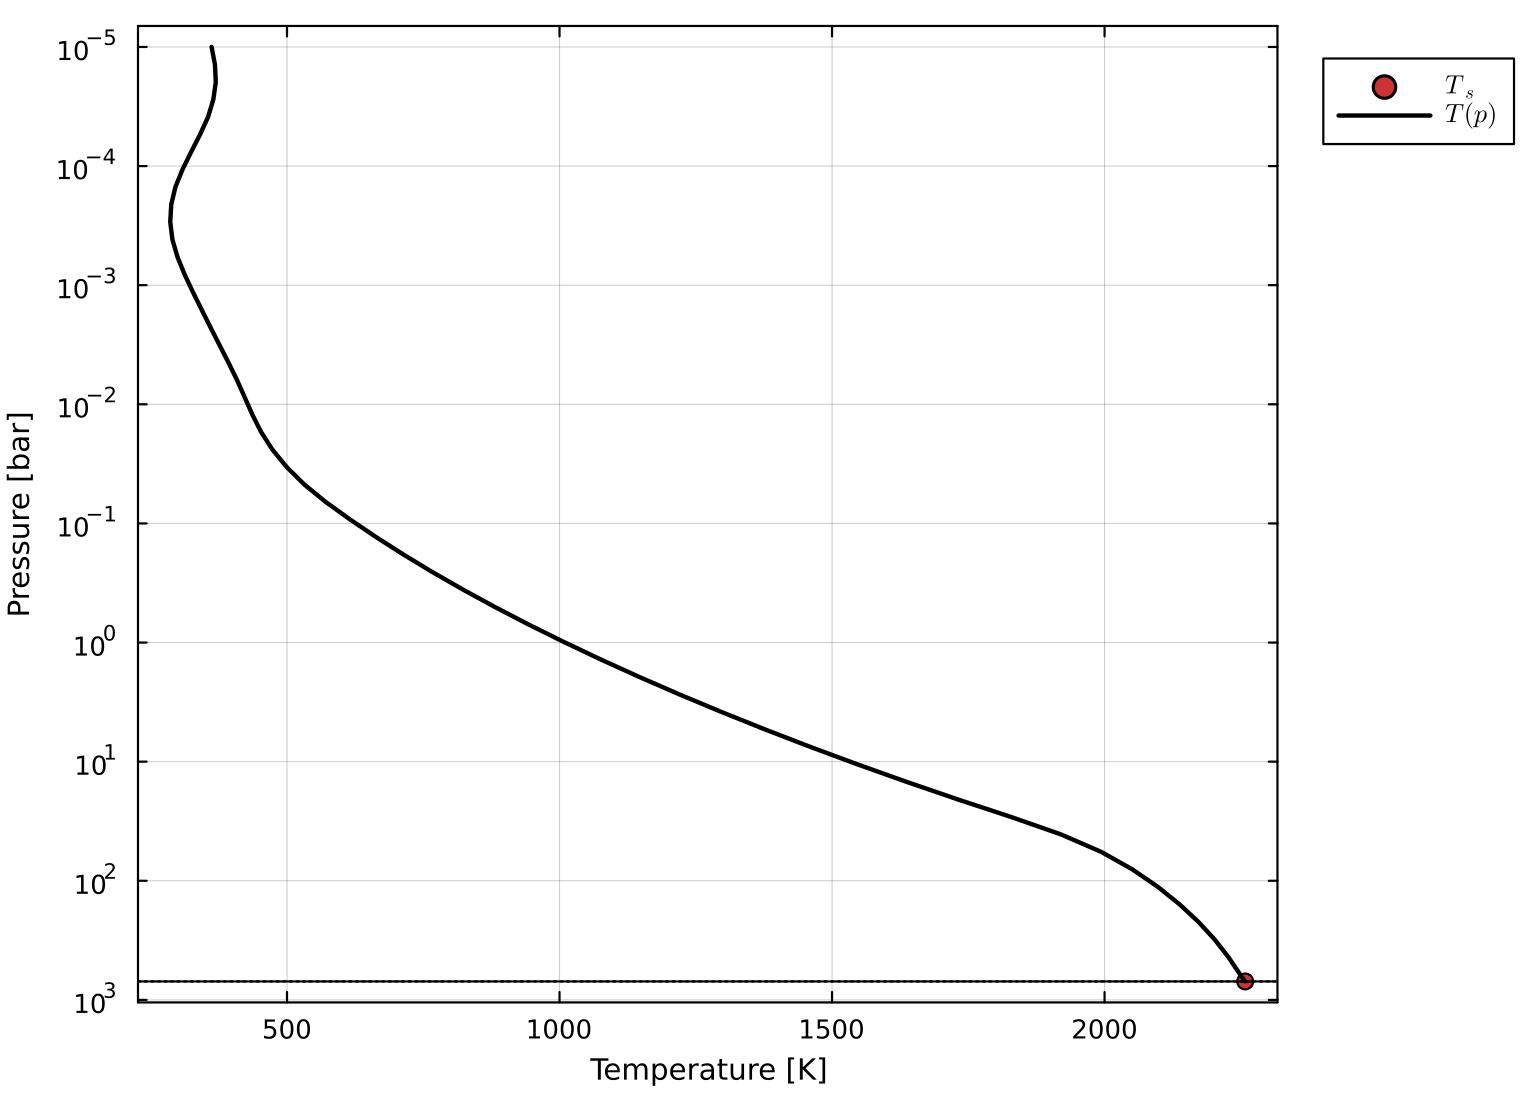

In [8]:
# Show the converged temperature profile
plt = plotting.plot_pt(atmos, "", size_x=700,size_y=500)

There are a few notable features:
* An radiative layer is formed near the surface. The atmosphere is optically thick in this region.
* Convection occurs between ~50 bar and ~0.05 bar.
* The atmosphere is purely radiative above 1 bar, with an inversion formed at pressures less than 0.3 mbar.
* The temperature becomes quite small in the upper atmosphere, because condensation is  disabled.

Now, what about the fluxes?
We can plot these in a similar manner...

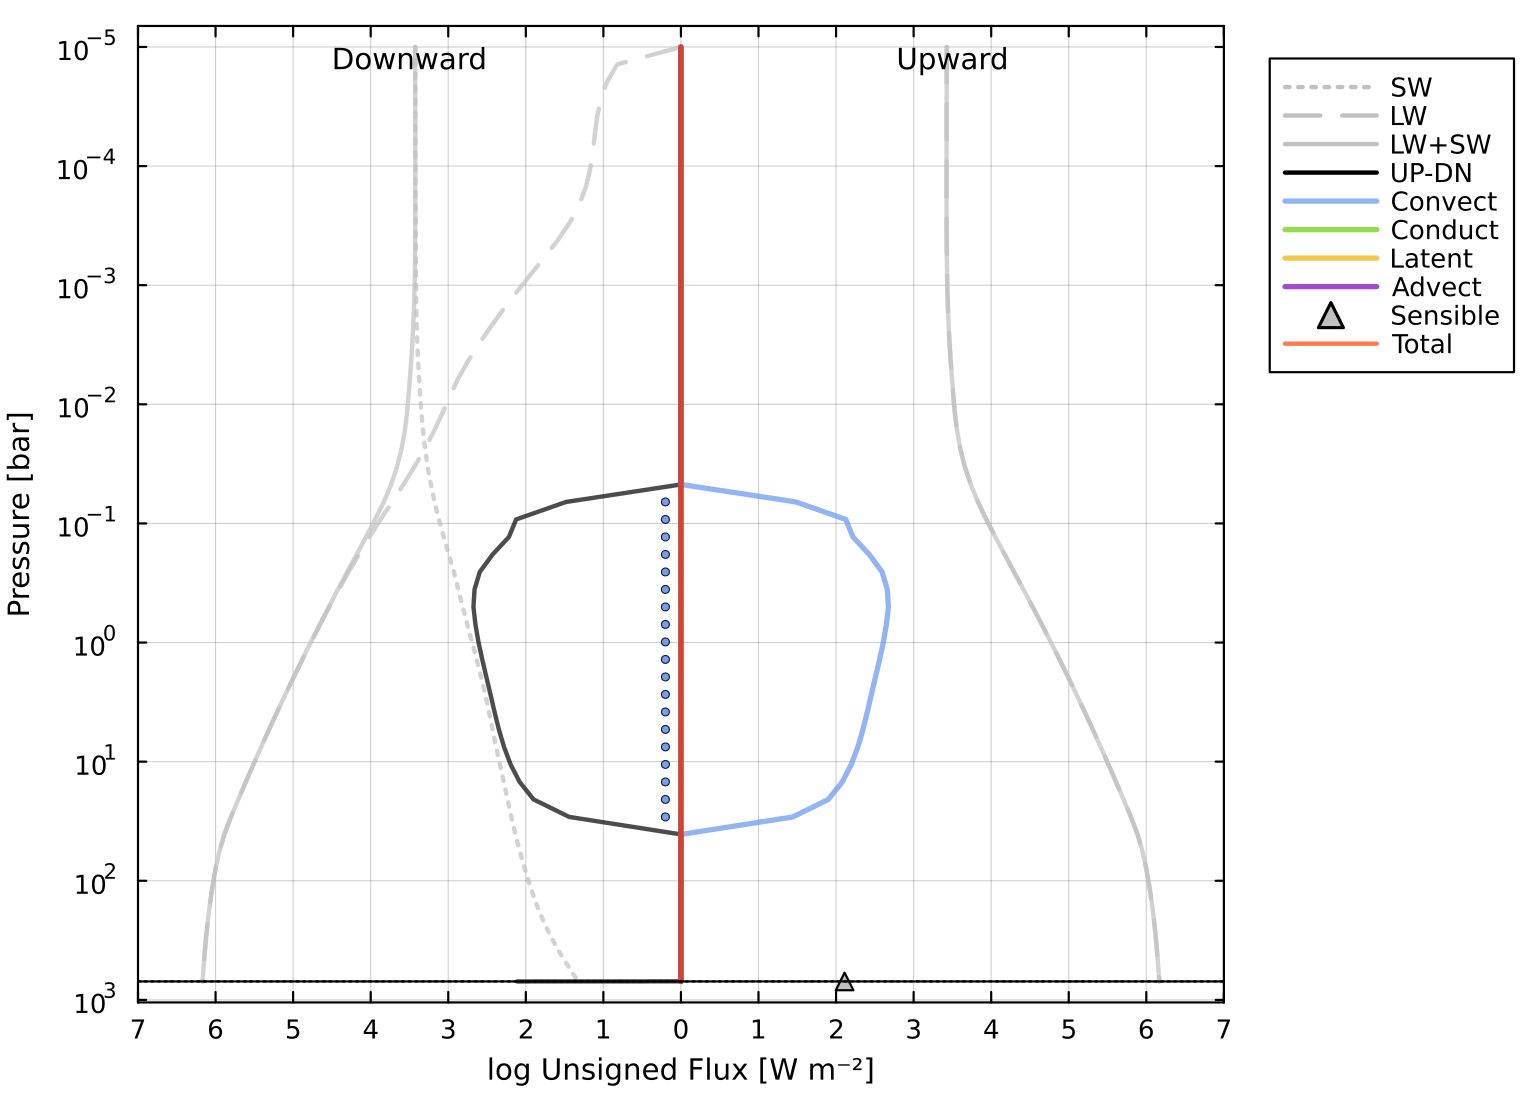

In [9]:
# Show the converged fluxes
plt = plotting.plot_fluxes(atmos, "", size_x=700,size_y=500)

This plot shows the upward (right side) and downward (left side) flux components. Note the log scale on the x-axis.   
We can see that the convective and radiative fluxes add to zero in the region of dry convection.    
Rayleigh scattering is turned off here, so the upward SW flux is zero.

## Try this!

Now, try running the model as an executable outside of this notebook.     
Do this by executing: `./agni.jl res/config/hotdry.toml` in the AGNI root directory.    
This will generate plots and data inside the output folder.